## Potrebni importi

In [ ]:
import zipfile
import os
import numpy as np
import pandas as pd
import shutil #za merge foldera
import xml.etree.ElementTree as ET #za xml

## Učitavanje zip datoteka i raspakiravanje

In [ ]:
path_to_zip_file = "drive/MyDrive/archive.zip"
directory_to_extract_to = "data/" #ovdje ce zavrsiti sve slike za trening

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [ ]:
#rucno oznacene slike
path_to_second_zip_file = "drive/MyDrive/ZaPklot.zip"
directory_to_extract_to = "data/PKLot/PKLot/" #ovako napravljeno da imam univerzalni pristup kasnije

alreadyExists=  os.path.exists(directory_to_extract_to)

if alreadyExists is False :

    os.mkdir("data/")
    os.mkdir("data/PKLot")
    os.mkdir("data/PKLot/PKLot")


with zipfile.ZipFile(path_to_second_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

Spoji sve slike iz foldera u 1

In [ ]:
# Definiramo izvorišne i odredišne mape
mysource_folder = "data/PKLot/PKLot"
mydestination_folder = "data/all" #ovdje spremamo sve slike
alreadyExists=  os.path.exists(mydestination_folder)

if alreadyExists is False :
    os.mkdir(mydestination_folder)
    # provjeri je li postoji


# prođi kroz SVE iz korijenskog direktorija
for root, dirs, files in os.walk(mysource_folder):

    # sve datoteke u trenutnom direktoriju
    for file in files:

        file_path = os.path.join(root, file)

        #kopiraj datoteku u ciljni direktorij
        os.rename(file_path, os.path.join(mydestination_folder, file))

    # poddirektoriji ovog direktorija
    for dir in dirs:

        dir_path = os.path.join(root, dir)

        # kopiraj sve u ciljni direktorij
        for subroot, subdirs, subfiles in os.walk(dir_path):
            for subfile in subfiles:
                subfile_path = os.path.join(subroot, subfile)

#link: https://www.tutorialspoint.com/how-to-merge-multiple-folders-into-one-folder-using-python

Pretvori xml u txt

In [ ]:
mysource_folder = "data/all"
label_files = [f for f in os.listdir(mysource_folder) if f.endswith(".xml")]

#velicina slika iz test seta
image_width = 1280
image_height = 720

class_mapping = {"1": 1, "0": 0} #je li is_occupied=1 ili is_occupied=0

for label_file in label_files:
  #spremi je u "data/train/images"
  xml_file=os.path.join(mysource_folder, label_file)
  txt_file = os.path.splitext(xml_file)[0] + ".txt"
  print(txt_file)
  txt_path = os.path.join(txt_file) #os.path.join(mysource_folder, txt_file)
  print(txt_path)
  #popuni txt file -> procitaj xml
  tree = ET.parse(xml_file)
  root = tree.getroot()

  with open(txt_path, 'w') as f:
    for space in root.findall("space"):
      is_occupied=space.get("occupied")

      class_index = class_mapping.get(is_occupied, -1) #u slucaju da nije pisalo ni 0 ni 1
      if class_index == -1:
                continue #nemoj ici dalje

      rotated_rect = space.find("rotatedRect")
      center = rotated_rect.find("center")
      size = rotated_rect.find("size")

      x = float(center.get("x"))
      y = float(center.get("y"))
      w = float(size.get("w"))
      h = float(size.get("h"))

      x = x / image_width
      y = y / image_height
      w = w / image_width
      h = h / image_height

      # iako u  xml-u ima informacija o kutu, ovdje je nema jer je yolo ne podrzava :)
      f.write(f"{class_index} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")


  # notebook po kojem  pratim korake: https://www.kaggle.com/code/denistopallaj/parking-lot-prediction/notebook

Struktura yolov8 za treniranje

In [ ]:
 ## └── train
 ####└── images
 ####└── labels
 ## └── test
 ####└── images
 ####└── labels
 ## └── valid
 ####└── images
 ####└── labels
 from sklearn.model_selection import train_test_split

#podjeli na train/test/val
input_folder='./data/all'

image_files = [f for f in os.listdir(input_folder) if f.endswith(".jpg")]
label_files = [f for f in os.listdir(input_folder) if f.endswith(".txt")]


train_images, valid_images = train_test_split(image_files, test_size=0.2, random_state=42)
valid_images, test_images = train_test_split(valid_images, test_size=0.2, random_state=42)

#stvori strukturu za spremiti sve
mydestination_folders = ["./data/train","./data/test","./data/val","./data/train/images","./data/train/labels",
                         "./data/test/images","./data/test/labels","./data/val/images","./data/val/labels"]
for dest_folder in mydestination_folders:
  if os.path.exists(dest_folder) is False:
     os.mkdir(dest_folder)


#train

#spremi slike gdje treba i test gdje treba
for image_file in train_images:
  #spremi je u "data/train/images"
  os.path.join(input_folder, image_file)
  shutil.copy2(input_folder+'/'+image_file,"data/train/images") # ovako kopiram na zeljenu lokaciju


  #pronađi odgovarajuću .txt i spremi nju u "data/train/labels"
  txt_file = os.path.splitext(image_file)[0] + ".txt"
  txt_path = os.path.join(input_folder, txt_file)
  if os.path.exists(txt_path):

    shutil.copy2(txt_path,"data/train/labels") # ovako kopiram na zeljenu lokaciju


#valid

#spremi slike gdje treba i test gdje treba
for image_file in valid_images:
  os.path.join(input_folder, image_file)
  shutil.copy2(input_folder+'/'+image_file,"data/val/images") # ovako kopiram na zeljenu lokaciju


  txt_file = os.path.splitext(image_file)[0] + ".txt"
  txt_path = os.path.join(input_folder, txt_file)
  if os.path.exists(txt_path):
    shutil.copy2(txt_path,"data/val/labels") # ovako kopiram na zeljenu lokaciju


for image_file in test_images:
  #spremi je u "data/train/images"
  os.path.join(input_folder, image_file)
  shutil.copy2(input_folder+'/'+image_file,"data/test/images") # ovako kopiram na zeljenu lokaciju



  txt_file = os.path.splitext(image_file)[0] + ".txt"
  txt_path = os.path.join(input_folder, txt_file) #provjeri
  if os.path.exists(txt_path):
    shutil.copy2(txt_path,"data/test/labels") # ovako kopiram na zeljenu lokaciju




## Treniranje modela

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.1/701.1 kB 8.9 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt") #pretrained
# Fine tuning
model.train(data="./data/data.yaml", epochs=15,save_dir='./data') #prouci sto treba, mozda bez svih ovih celija i probati yolov3? ugl provjeri,drive/MyDrive/data.yaml ne radi iza, zasad rucno dodaj datu

Ultralytics YOLOv8.1.3 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=./data/data.yaml, epochs=15, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

train: Scanning /content/data/train/labels.cache... 188 images, 7 backgrounds, 0 corrupt: 100%|██████████| 195/195 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/data/val/labels.cache... 38 images, 1 backgrounds, 0 corrupt: 100%|██████████| 39/39 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      4.19G      2.425      3.037       2.12         39        640: 100%|██████████| 13/13 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all         39        325      0.605      0.804      0.725      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      4.24G      1.643       1.21      1.378         42        640: 100%|██████████| 13/13 [00:04<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         39        325       0.81      0.889      0.893       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      4.29G       1.58     0.9864      1.283         57        640: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         39        325      0.855      0.812      0.901      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15       4.2G      1.489     0.9146      1.247         31        640: 100%|██████████| 13/13 [00:04<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         39        325      0.939      0.888       0.97      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      4.27G      1.449     0.8513      1.208         35        640: 100%|██████████| 13/13 [00:04<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         39        325      0.891      0.921      0.964       0.62


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      4.23G      1.435     0.8395      1.239         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


                   all         39        325      0.848      0.932      0.931      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      4.15G      1.399     0.7821      1.208         27        640: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]

                   all         39        325       0.92      0.897      0.963      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      4.18G      1.365     0.7657      1.217         27        640: 100%|██████████| 13/13 [00:03<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         39        325      0.859       0.96      0.949      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      4.18G      1.326     0.7278      1.175         28        640: 100%|██████████| 13/13 [00:03<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         39        325      0.959      0.908      0.962      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      4.24G      1.303     0.7903      1.179          8        640: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         39        325      0.913      0.907       0.96      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      4.23G      1.288     0.6719      1.157         25        640: 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         39        325      0.865      0.924      0.967      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      4.17G      1.292     0.6939       1.16         18        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         39        325      0.961      0.939       0.98      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      4.19G      1.239       0.62      1.142         25        640: 100%|██████████| 13/13 [00:03<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         39        325       0.98       0.95      0.984      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      4.22G      1.219     0.6199      1.136         20        640: 100%|██████████| 13/13 [00:04<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         39        325      0.986      0.939      0.985      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      4.17G      1.212     0.5875      1.119         27        640: 100%|██████████| 13/13 [00:03<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         39        325       0.98      0.948      0.981      0.652



15 epochs completed in 0.033 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 22.5MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.1.3 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]


                   all         39        325       0.98       0.95      0.984      0.655
                 empty         39        160      0.988      0.998      0.994      0.653
              occupied         39        165      0.972      0.903      0.974      0.657
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b5718c79ed0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

## Testiranje modela

Potrebni importi

In [ ]:
#potrebni importi

from ntpath import join
#from imageai.Detection import VideoObjectDetection
#from imageai.Detection.Custom import CustomVideoObjectDetection
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob
from PIL import Image
import torch
import random

Random slika iz test odjeljka


image 1/1 /content/data/test/images/velikiParking232.jpg: 384x640 10 emptys, 16 occupieds, 16.5ms
Speed: 2.7ms preprocess, 16.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/train62


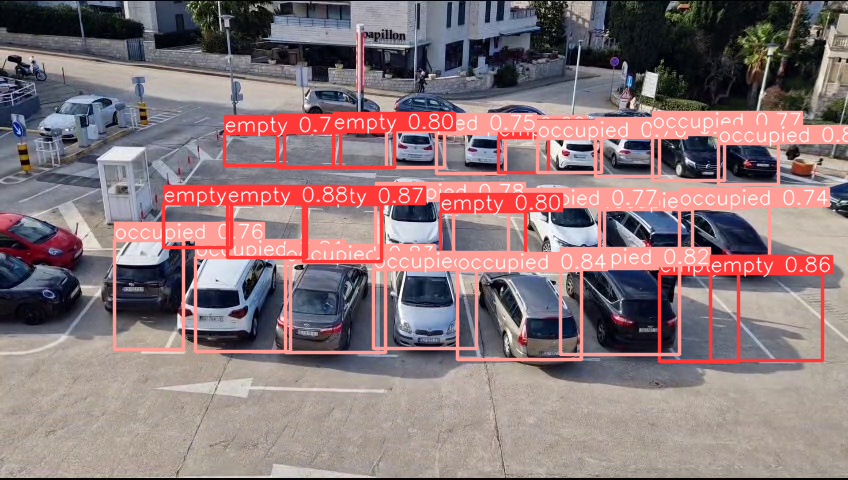

In [ ]:
test_images_directory = "./data/test/images"

image_files = [f for f in os.listdir(test_images_directory) if f.lower().endswith(".jpg")]

random_image_filename = random.choice(image_files)
random_image_path = os.path.join(test_images_directory, random_image_filename)

results = model.predict(random_image_path,save=True) # automatski sprema rez :)

result = results[0]

Image.fromarray(result.plot()[:,:,::-1]) #ovo nam treba zbog boja da su ispravne

Testiranje videa nastalih yolo modelom primjenjenim na cijeli video

In [ ]:
results2 = list(model.predict("./danDugiTest.mp4",save=True,stream=True,conf = 0.45))  # u ovoj verziji vidimo rezultate za gotovi video, 15 epoha, zadnja ver 0.6,sad 0.45


video 1/1 (1/1374) /content/danDugiTest.mp4: 384x640 3 emptys, 6 occupieds, 36.8ms
video 1/1 (2/1374) /content/danDugiTest.mp4: 384x640 3 emptys, 6 occupieds, 17.0ms
video 1/1 (3/1374) /content/danDugiTest.mp4: 384x640 3 emptys, 6 occupieds, 26.5ms
video 1/1 (4/1374) /content/danDugiTest.mp4: 384x640 3 emptys, 6 occupieds, 18.7ms
video 1/1 (5/1374) /content/danDugiTest.mp4: 384x640 3 emptys, 6 occupieds, 13.6ms
video 1/1 (6/1374) /content/danDugiTest.mp4: 384x640 3 emptys, 6 occupieds, 15.9ms
video 1/1 (7/1374) /content/danDugiTest.mp4: 384x640 3 emptys, 6 occupieds, 17.2ms
video 1/1 (8/1374) /content/danDugiTest.mp4: 384x640 3 emptys, 6 occupieds, 15.4ms
video 1/1 (9/1374) /content/danDugiTest.mp4: 384x640 3 emptys, 6 occupieds, 14.5ms
video 1/1 (10/1374) /content/danDugiTest.mp4: 384x640 3 emptys, 6 occupieds, 11.9ms
video 1/1 (11/1374) /content/danDugiTest.mp4: 384x640 3 emptys, 6 occupieds, 11.3ms
video 1/1 (12/1374) /content/danDugiTest.mp4: 384x640 3 emptys, 6 occupieds, 13.7ms


In [ ]:
results2 = list(model.predict("./mrakTest.mp4",save=True,stream=True,conf = 0.45))  # u ovoj verziji vidimo rezultate za gotovi video, 04 i 45,05, provjeri sve


video 1/1 (1/705) /content/mrakTest.mp4: 384x640 3 emptys, 6 occupieds, 14.6ms
video 1/1 (2/705) /content/mrakTest.mp4: 384x640 3 emptys, 6 occupieds, 10.9ms
video 1/1 (3/705) /content/mrakTest.mp4: 384x640 3 emptys, 6 occupieds, 11.4ms
video 1/1 (4/705) /content/mrakTest.mp4: 384x640 3 emptys, 6 occupieds, 15.7ms
video 1/1 (5/705) /content/mrakTest.mp4: 384x640 3 emptys, 6 occupieds, 10.7ms
video 1/1 (6/705) /content/mrakTest.mp4: 384x640 3 emptys, 6 occupieds, 10.7ms
video 1/1 (7/705) /content/mrakTest.mp4: 384x640 3 emptys, 6 occupieds, 12.4ms
video 1/1 (8/705) /content/mrakTest.mp4: 384x640 3 emptys, 6 occupieds, 10.7ms
video 1/1 (9/705) /content/mrakTest.mp4: 384x640 3 emptys, 7 occupieds, 10.7ms
video 1/1 (10/705) /content/mrakTest.mp4: 384x640 3 emptys, 6 occupieds, 10.7ms
video 1/1 (11/705) /content/mrakTest.mp4: 384x640 3 emptys, 6 occupieds, 10.7ms
video 1/1 (12/705) /content/mrakTest.mp4: 384x640 3 emptys, 7 occupieds, 10.7ms
video 1/1 (13/705) /content/mrakTest.mp4: 384x64

In [ ]:
results2 = list(model.predict("./nepomicniTest.mp4",save=True,stream=True,conf=0.45))  # u ovoj verziji vidimo rezultate za gotovi video


video 1/1 (1/516) /content/nepomicniTest.mp4: 384x640 1 empty, 4 occupieds, 13.5ms
video 1/1 (2/516) /content/nepomicniTest.mp4: 384x640 1 empty, 4 occupieds, 20.9ms
video 1/1 (3/516) /content/nepomicniTest.mp4: 384x640 1 empty, 4 occupieds, 13.3ms
video 1/1 (4/516) /content/nepomicniTest.mp4: 384x640 1 empty, 4 occupieds, 13.9ms
video 1/1 (5/516) /content/nepomicniTest.mp4: 384x640 4 occupieds, 11.8ms
video 1/1 (6/516) /content/nepomicniTest.mp4: 384x640 1 empty, 4 occupieds, 10.7ms
video 1/1 (7/516) /content/nepomicniTest.mp4: 384x640 4 occupieds, 11.9ms
video 1/1 (8/516) /content/nepomicniTest.mp4: 384x640 4 occupieds, 10.7ms
video 1/1 (9/516) /content/nepomicniTest.mp4: 384x640 4 occupieds, 10.7ms
video 1/1 (10/516) /content/nepomicniTest.mp4: 384x640 4 occupieds, 11.3ms
video 1/1 (11/516) /content/nepomicniTest.mp4: 384x640 4 occupieds, 10.7ms
video 1/1 (12/516) /content/nepomicniTest.mp4: 384x640 1 empty, 4 occupieds, 10.6ms
video 1/1 (13/516) /content/nepomicniTest.mp4: 384x640

In [ ]:
results2 = list(model.predict("./parkingTest2.mp4",save=True,stream=True))

In [ ]:
results2 = list(model.predict("./data/parkingBruno.mp4",save=True,stream=True))

In [ ]:
results2 = list(model.predict("./data/drugiKut.mp4",save=True,stream=True))

In [ ]:
results2 = list(model.predict("./data/noviParking.mp4",save=True,stream=True))

In [ ]:
results2 = list(model.predict("./data/velikiParking.mp4",save=True,stream=True))

In [ ]:
results2 = list(model.predict("./data/autoParkira.mp4",save=True,stream=True))

In [ ]:
results2 = list(model.predict("./data/parkingDBK.mp4",save=True,stream=True))

In [ ]:
results2 = list(model.predict("./data/parkingPrazan.mp4",save=True,stream=True))

In [ ]:
results2 = list(model.predict("./data/parkingBocno.mp4",save=True,stream=True))

Spremi sve rezultate u zip file

In [ ]:
import shutil
shutil.make_archive("/content/drive/MyDrive/ColabFiles/MojeOznale_20_15ep", 'zip', "/content/runs/detect")

'/content/drive/MyDrive/ColabFiles/MojeOznale_20_15ep.zip'

Nedostatak ove metode: problemi s predugim videom, pogodna za analiziranje vec snimljenih videa, ali ne za livestream.

Ovaj dio koda video prvo pretvori u slike i zatim slike opet vrati u video:
korišteno na samom početku pisanja programa

In [ ]:
#video pretvori u slike, (napravi predikciju u ovom slučaju je već napravljena) i spremi
video = cv2.VideoCapture('drive/MyDrive/parkingTest3.mp4')

# odredi fps
fps = video.get(cv2.CAP_PROP_FPS)
print('frames per second =',fps)


directory_to_extract_to = "data/parkingTest"

alreadyExists=  os.path.exists(directory_to_extract_to)

if alreadyExists is False :
    os.mkdir(directory_to_extract_to)

frames per second = 30.0


In [ ]:
count=0
while video.isOpened():

    success, image = video.read()

    if success:
      if count < 10:
        cnt='0'+str(count)
      else :
        cnt=count
      cv2.imwrite("./data/parkingTest/frame%s.jpg" % cnt, image)

      print('Read a new frame: ', success)
      count += 1


    else:

        break

video.release()
cv2.destroyAllWindows()

In [ ]:
#helper function
import re

def myFunc(e):
  rez= re.sub(r'\D', '', e)
  print(rez)
  return int(rez)

In [ ]:
import natsort
img_array = []

# Get the list of image files in the directory
images = [img for img in os.listdir('./data/parkingTest') if img.endswith(".jpg")]

# Sort the images based on their filenames
images.sort(key=myFunc) #ey=myFunc  lambda f: int(filter(str.isdigit, f))

#print(images[10])

for filename in images:  # ovo su frameovi iz videa na ulazu
    img = cv2.imread(os.path.join('./data/parkingTest/', filename))
    try:
      img.shape
      print("checked for shape".format(img.shape ) + filename)
    except AttributeError:
      print("shape not found " + filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('parkingTest3.avi',cv2.VideoWriter_fourcc(*'DIVX'), fps, size) #imam frameove

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

Video koji kao ulaz dobiva livestream i prikazuje rješenje u otvorenom prozoru, primjena u stvarnom svijetu.

In [ ]:
from collections import OrderedDict
from ultralytics import YOLO
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image


model = YOLO("best.pt")  # pretrained
video = cv2.VideoCapture('nepomicniTest.mp4')  # 0 iz kamere
while video.isOpened():
    # Procitaj frame iz videa
    success, frame = video.read()

    if success:

        print("Read a new frame: ", success)

        # primjeni yolo8
        results = model.predict(frame)

        # Vizualizacija rezultata
        annotated_frame = results[0].plot()

        # Prikaz u prozoru
        cv2.imshow(
            "YOLOv8 Inference", annotated_frame
        )  # cv2.imshow() nije omogucen u  Colab, uzrokuje da se Jupyter sesije crashaju , tako da se ovo pokrece lokalno
        if cv2.waitKey(1) == ord("q"):
            break
    else:

        break


# zatvori prozor
video.release()
cv2.destroyAllWindows()

## Zaključak: Model radi najbolje kad se koristi samo ručno označena mjesta. Za bolju generalizaciju potrebno je više različitih slika.
